In [1]:
from SimPEG import DC
import numpy as np
from SimPEG import Mesh, Maps, Utils
from pymatsolver import PardisoSolver
from ipywidgets import *
%pylab inline
from matplotlib import colors
from simpegEMIP.SeogiUtils.View import Circle2D
import h5py
from pylab import cm
from matplotlib import gridspec

Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['interactive', 'Button', 'Text', 'Widget']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
work_dir = "../data/"
fname = 'output_simulation_sip.h5'
output_simulation = h5py.File(work_dir+fname, 'r')
geology_names = np.array(["background", "overburden","porphyry", "stock", "halo", "clay", "mineralization"], dtype=str),    

In [3]:
mesh = Mesh.TensorMesh.readUBC(work_dir+output_simulation['mesh_name'].value)
sigma = output_simulation['sigma'].value
eta = output_simulation['eta'].value
tau = output_simulation['tau'].value
c = output_simulation['c'].value

In [4]:
print (mesh)

  ---- 3-D TensorMesh ----  
   x0: -500.00
   y0: -487.50
   z0: -180.00
  nCx: 80
  nCy: 38
  nCz: 18
   hx: 80*12.50,
   hy: 38*25.00,
   hz: 18*10.00,


In [5]:
IO_3d = DC.IO()
survey_3d = IO_3d.from_ambn_locations_to_survey(
    survey_type='dipole-dipole',
    a_locations=output_simulation['a_locations'].value,
    b_locations=output_simulation['b_locations'].value,
    m_locations=output_simulation['m_locations'].value,
    n_locations=output_simulation['n_locations'].value,
    data_dc=output_simulation['dc_data'].value,
    data_dc_type='volt',
    data_sip=output_simulation['sip_data'].value,    
    data_sip_type='volt',
    line_inds = output_simulation['line_inds'].value,
    dimension=3
)
mesh_3d, actind = IO_3d.set_mesh(dx=25., dy=50., dz=15., dimension=3)
actMap = Maps.InjectActiveCells(mesh_3d, actind, valInactive=np.log(1e-8))
sigmaMap = Maps.ExpMap(mesh_3d)*actMap

problem_dc = DC.Problem3D_N(
    mesh_3d, sigmaMap=sigmaMap,
    storeJ=True,
    Solver=PardisoSolver
)
problem_dc.pair(survey_3d)
core_3d_inds, mesh_3d_core = Utils.ExtractCoreMesh(IO_3d.xyzlim, mesh_3d)


/Users/sgkang/Projects/simpeg/SimPEG/EM/Static/DC/IODC.py:229: UserWarning: code under construction - API might change in the future
  "code under construction - API might change in the future"


In [18]:
geometric_factor = survey_3d.set_geometric_factor(
    data_type="volt",
    survey_type='dipole-dipole',
    space_type='half-space'
)

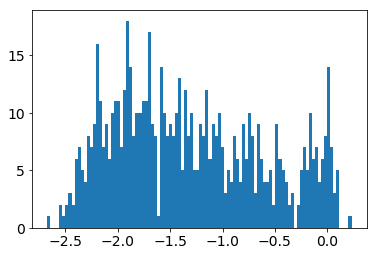

In [20]:
out = hist(np.log10(abs(IO_3d.voltages)), bins=100)

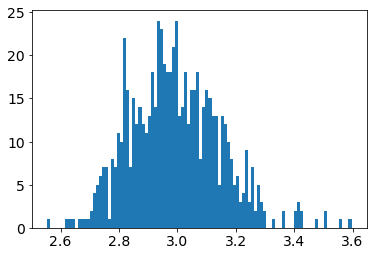

In [22]:
out = hist(np.log10(abs(IO_3d.voltages/IO_3d.G)), bins=100)

In [23]:
import numpy as np
from SimPEG import (Maps, DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)


def run_inversion(
    m0, survey, actind, mesh,
    std, eps,
    maxIter=15, beta0_ratio=1e0,
    coolingFactor=5, coolingRate=2,
    upper=np.inf, lower=-np.inf,
    use_sensitivity_weight=True,
    alpha_s=1e-4,
    alpha_x=1.,
    alpha_y=1.,
    alpha_z=1.,
):
    """
    Run DC inversion
    """
    dmisfit = DataMisfit.l2_DataMisfit(survey)
    uncert = abs(survey.dobs) * std + eps
    dmisfit.W = 1./uncert
    # Map for a regularization
    regmap = Maps.IdentityMap(nP=int(actind.sum()))
    # Related to inversion
    if use_sensitivity_weight:
        reg = Regularization.Sparse(mesh, indActive=actind, mapping=regmap)
        reg.alpha_s = alpha_s
        reg.alpha_x = alpha_x
        reg.alpha_y = alpha_y
        reg.alpha_z = alpha_z
    else:
        reg = Regularization.Sparse(mesh, indActive=actind, mapping=regmap)
        reg.alpha_s = alpha_s
        reg.alpha_x = alpha_x
        reg.alpha_y = alpha_y
        reg.alpha_z = alpha_z

    opt = Optimization.ProjectedGNCG(maxIter=maxIter, upper=upper, lower=lower)
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
    beta = Directives.BetaSchedule(
        coolingFactor=coolingFactor, coolingRate=coolingRate
    )
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
    target = Directives.TargetMisfit()
    # Need to have basice saving function
    update_Jacobi = Directives.UpdatePreconditioner()
    reg.norms = np.c_[0, 1, 1, 1]
    IRLS = Directives.Update_IRLS(
        maxIRLSiter=20, minGNiter=1,
        betaSearch=False, fix_Jmatrix=True
    )    
    if use_sensitivity_weight:
        updateSensW = Directives.UpdateSensitivityWeights()
        directiveList = [
            beta, betaest, updateSensW, IRLS
        ]
    else:
        directiveList = [
            betaest, IRLS
        ]
    inv = Inversion.BaseInversion(
        invProb, directiveList=directiveList
        )
    opt.LSshorten = 0.5
    opt.remember('xc')

    # Run inversion
    mopt = inv.run(m0)
    return mopt, invProb.dpred



In [13]:
survey_3d.dobs = IO_3d.voltages
m0_dc = np.ones(actind.sum())*np.log(1./1e3)
mopt_dc, pred_dc = run_inversion(
    m0_dc, survey_3d, actind, mesh_3d, 0.05, 10**-3.5, use_sensitivity_weight=True,
    alpha_y=1., alpha_s=0.1, maxIter=15
)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:886: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.10e+00  9.45e+03  0.00e+00  9.45e+03    1.13e+03      0              
   1  1.05e+00  1.49e+03  4.24e+01  1.54e+03    4.07e+02      0              
   2  1.05e-01  4.27e+02  4.34e+01  4.32e+02    1.20e+02      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 1.6072367728738097 eps_q: 1.6072367728738097
>> Fix Jmatrix
Eps_p: 1.3393639773948416
Eps_q: 1.3393639773948416
delta phim:    inf


/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:763: RuntimeWarning: divide by zero encountered in double_scalars
  self.f_change = np.abs(self.f_old - phim_new) / self.f_old


   3  5.26e-02  3.21e+02  6.15e+01  3.24e+02    7.42e+01      0              
>> Fix Jmatrix
Eps_p: 1.1161366478290347
Eps_q: 1.1161366478290347
delta phim: 2.979e-01
   4  1.70e-02  2.76e+02  6.47e+01  2.77e+02    5.71e+01      0              
>> Fix Jmatrix
Eps_p: 0.9301138731908623
Eps_q: 0.9301138731908623
delta phim: 2.506e-01
   5  2.96e-02  2.27e+02  7.90e+01  2.29e+02    5.50e+01      0              
>> Fix Jmatrix
Eps_p: 0.7750948943257185
Eps_q: 0.7750948943257185
delta phim: 4.558e-01
   6  1.07e-02  2.08e+02  8.69e+01  2.09e+02    4.87e+01      0              
>> Fix Jmatrix
Eps_p: 0.6459124119380988
Eps_q: 0.6459124119380988
delta phim: 2.201e-01
   7  1.98e-02  2.00e+02  9.42e+01  2.02e+02    3.04e+01      0              
>> Fix Jmatrix
Eps_p: 0.538260343281749
Eps_q: 0.538260343281749
delta phim: 2.207e-01
   8  7.48e-03  1.90e+02  1.03e+02  1.91e+02    3.93e+01      0              
>> Fix Jmatrix
Eps_p: 0.4485502860681242
Eps_q: 0.4485502860681242
delta phim: 2.155e-01


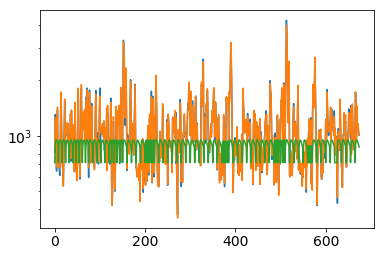

In [17]:
plt.semilogy(abs(pred_dc))
plt.semilogy(abs(survey_3d.dobs))

/Users/sgkang/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/sgkang/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


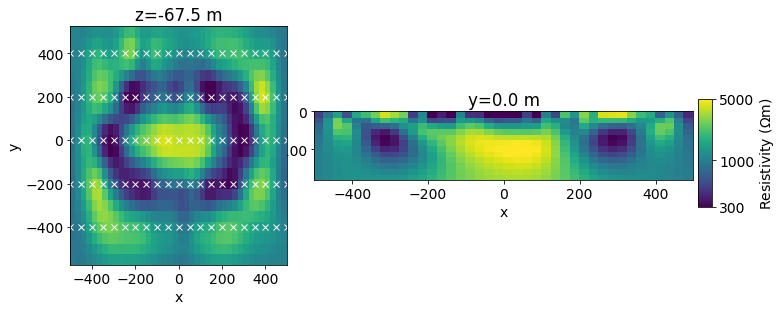

In [16]:
import matplotlib
matplotlib.rcParams['font.size'] = 14
sigma_est = sigmaMap * mopt_dc
yc = 0
indy = int(np.argmin(abs(mesh_3d_core.vectorCCy-yc)))
zc = -70
indz = int(np.argmin(abs(mesh_3d_core.vectorCCz-zc)))

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 8)
ax1 = plt.subplot(gs[0, 3:])
ax2 = plt.subplot(gs[0, :3])
vmin, vmax = 300, 5000.
out = mesh_3d_core.plotSlice(
    1./sigma_est[core_3d_inds], grid=False, normal="Y", clim=(vmin, vmax), pcolorOpts={'cmap':'viridis', 'norm':colors.LogNorm()}, ax=ax1, ind=indy
)
ax1.set_aspect("equal")
ax1.set_title(("y=%.1f m")%(mesh_3d_core.vectorCCy[indy]))
out = mesh_3d_core.plotSlice(
    1./sigma_est[core_3d_inds], grid=False, normal="Z", clim=(vmin, vmax), ind=indz, pcolorOpts={'cmap':'viridis', 'norm':colors.LogNorm()}, 
    ax=ax2
)
ax2.set_aspect(1)
ax2.set_title(("z=%.1f m")%(mesh_3d_core.vectorCCz[indz]))
ax2.plot(IO_3d.electrode_locations[:,0], IO_3d.electrode_locations[:,1], 'wx', markeredgewidth=1.)
cbaxes = fig.add_axes([0.98, 0.35, 0.02, 0.3]) 
cb=plt.colorbar(
    out[0], cax=cbaxes, orientation="vertical", ax=ax1, ticks=[300, 1000., 5000.]
)

cb.set_ticklabels(np.array([300, 1000., 5000.], dtype=int))
cb.set_label("Resistivity ($\Omega$m)")
for ax in [ax1, ax2]:
    ax.set_xlim(-500, 500)
#     ax.set_ylim(-500, 500)    
plt.tight_layout()


In [12]:
!rm -f output_dc_inversion.h5

In [13]:
import h5py
mesh_name = 'mesh_3d_dc.txt'
mesh_3d.writeUBC(mesh_name)
output_dc_inversion = {
    'mesh_name': mesh_name,
    'sigma': sigma_est,
    'dc_data': survey_3d.dobs,
    'dc_data_pred': pred_dc
}
def save_dict_to_hdf5(fname, dictionary):
    """
    Save a dictionary to hdf5
    """
    f = h5py.File(fname, "w")
    for key in dictionary.keys():
        dset = f.create_dataset(key, data=dictionary[key])
    f.close()
save_dict_to_hdf5('output_dc_inversion.h5', output_dc_inversion)